<a href="https://colab.research.google.com/github/eseinctz/calis/blob/main/CALIS_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysmt
!pysmt-install --z3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.1/326.1 kB 8.0 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
This script allows you to install the solvers supported by pySMT.

By executing this script, you confirm that you have read and agreed
with the licenses of each solver.

Notice: the installation process might require building tools
        (e.g., make and gcc).

Continue? [Y]es/[N]o: Y
Error processing line 1 of /usr/local/lib/python3.11

In [ ]:
!pip install pycryptodome
!pip install tinyec
!pip install ascon

In [ ]:
!pip install ecdsa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 6.1 MB/s eta 0:00:00



Encryption Algorithm Classification Report:
                   precision    recall  f1-score   support

      AES-128-GCM       1.00      1.00      1.00      5236
        ASCON-128       1.00      1.00      1.00     17739
ChaCha20-Poly1305       1.00      1.00      1.00      3585

         accuracy                           1.00     26560
        macro avg       1.00      1.00      1.00     26560
     weighted avg       1.00      1.00      1.00     26560


Key Rotation Frequency MSE: 1.27e-03


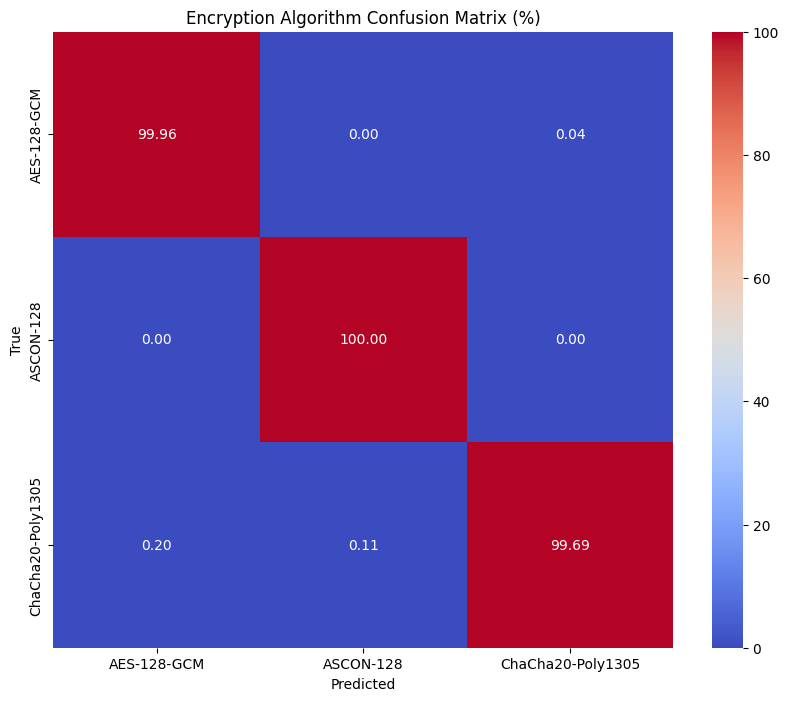

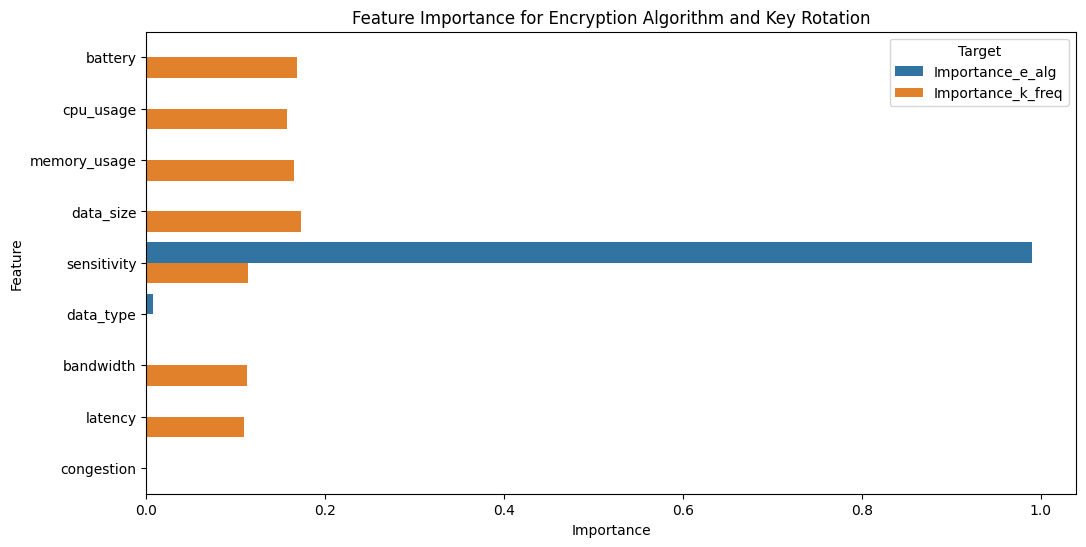

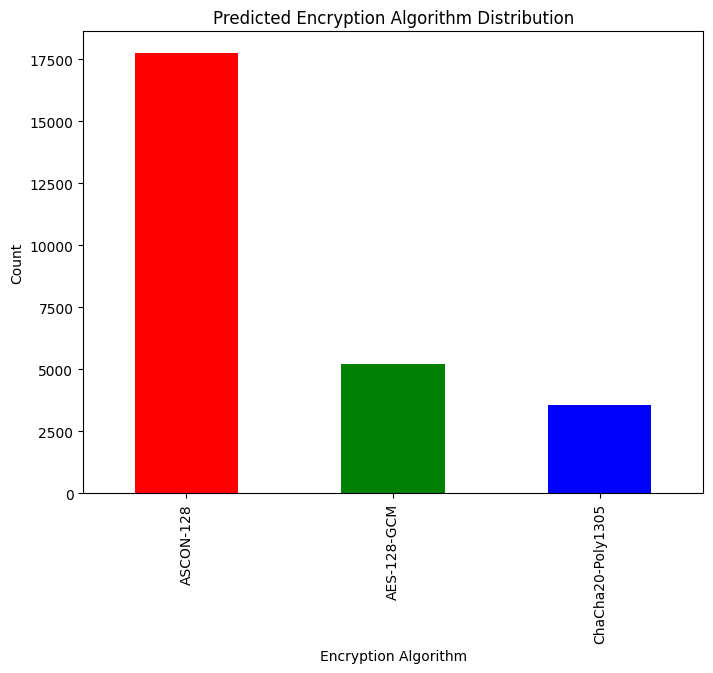

/tmp/ipython-input-15-1957189060.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores_e_alg, cv_scores_k_freq], labels=['Accuracy (e_alg)', 'MSE (k_freq)'])


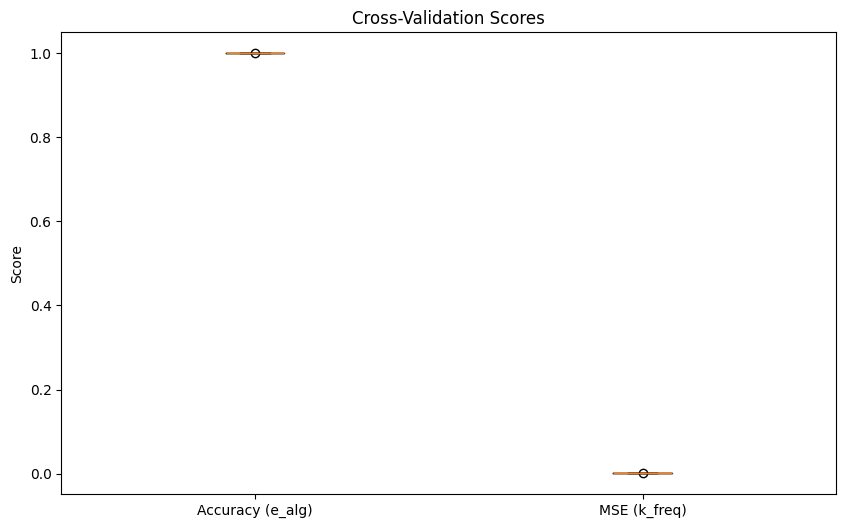

ASCON-128 Encryption Computation Time: 0.39 ms
ASCON-128 Decryption Computation Time: 0.31 ms
ASCON-128 Encryption Computation Time: 0.42 ms
ASCON-128 Decryption Computation Time: 0.42 ms
ASCON-128 Encryption Computation Time: 0.42 ms
ASCON-128 Decryption Computation Time: 0.42 ms
ASCON-128 Encryption Computation Time: 0.46 ms
ASCON-128 Decryption Computation Time: 0.43 ms
ASCON-128 Encryption Computation Time: 0.40 ms
ASCON-128 Decryption Computation Time: 0.39 ms
ASCON-128 Encryption Computation Time: 0.48 ms
ASCON-128 Decryption Computation Time: 0.39 ms
ASCON-128 Encryption Computation Time: 0.42 ms
ASCON-128 Decryption Computation Time: 0.39 ms
ASCON-128 Encryption Computation Time: 0.41 ms
ASCON-128 Decryption Computation Time: 0.40 ms
ASCON-128 Encryption Computation Time: 0.44 ms
ASCON-128 Decryption Computation Time: 0.43 ms
ASCON-128 Encryption Computation Time: 0.41 ms
ASCON-128 Decryption Computation Time: 0.38 ms
ASCON-128 Encryption Computation Time: 0.39 ms
ASCON-128 Dec

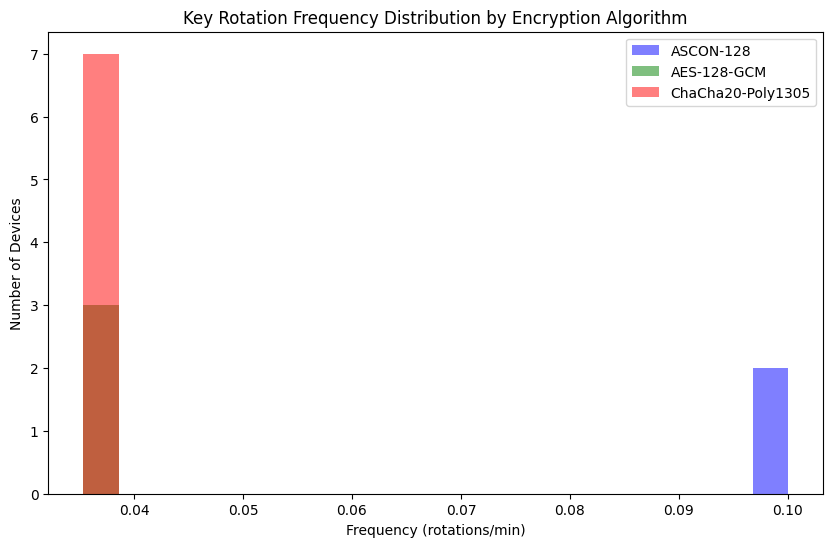


Performance Comparison with Static AES-256 Baseline:
     Scheme  Memory (bytes)  Energy (mJ)  Execution Time (ms)  \
0    SDN-24             215   190.000000            16.000000   
1    ELE-23             180   160.000000            12.000000   
2     Aegis             200   180.000000            18.000000   
3    SKICAP             195   280.000000            22.000000   
4  Proposed             143     9.662666             6.441777   

   Comm Overhead (bytes)  
0                    295  
1                    250  
2                    280  
3                    340  
4                     99  


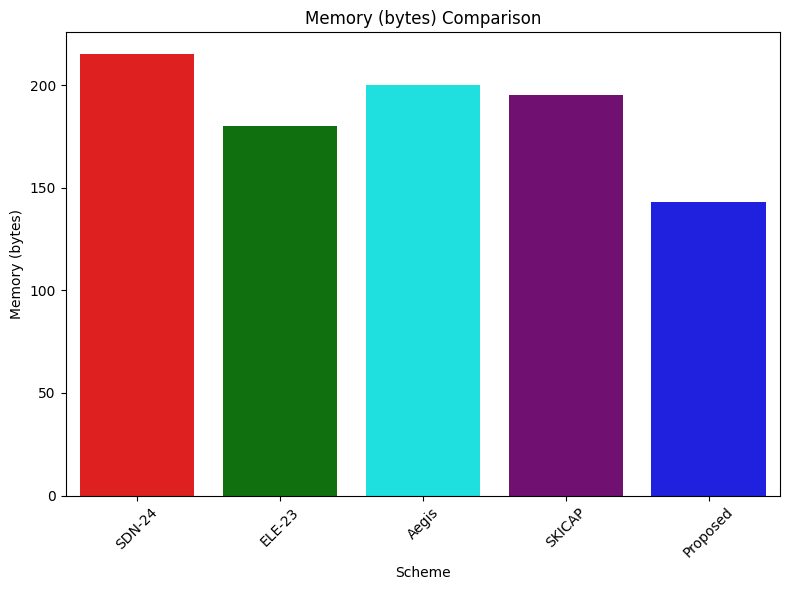

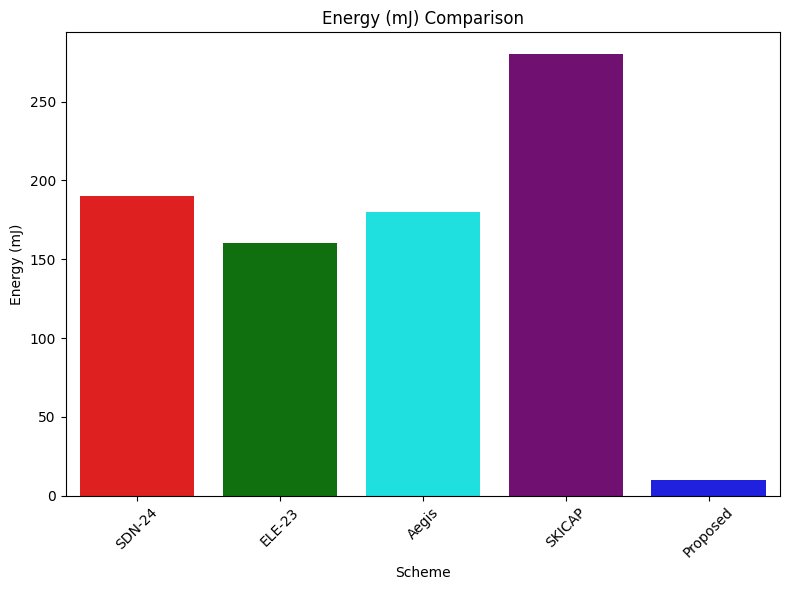

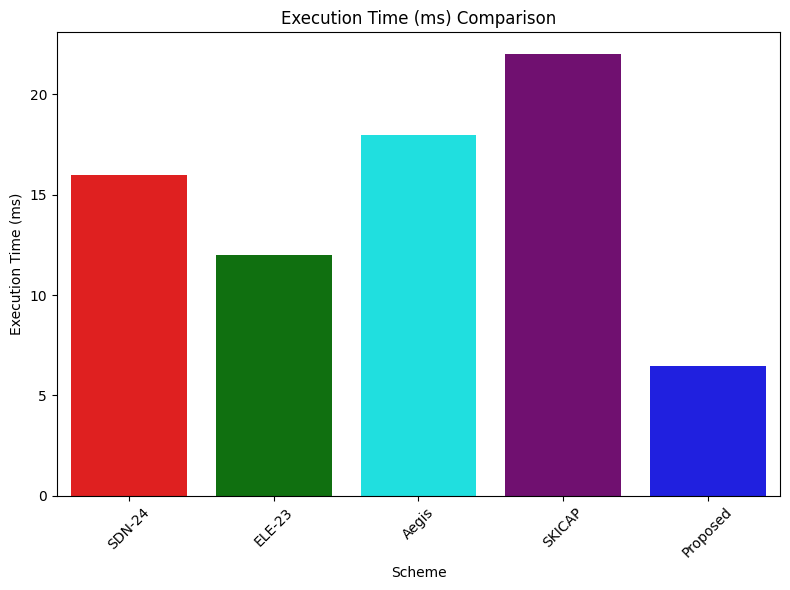

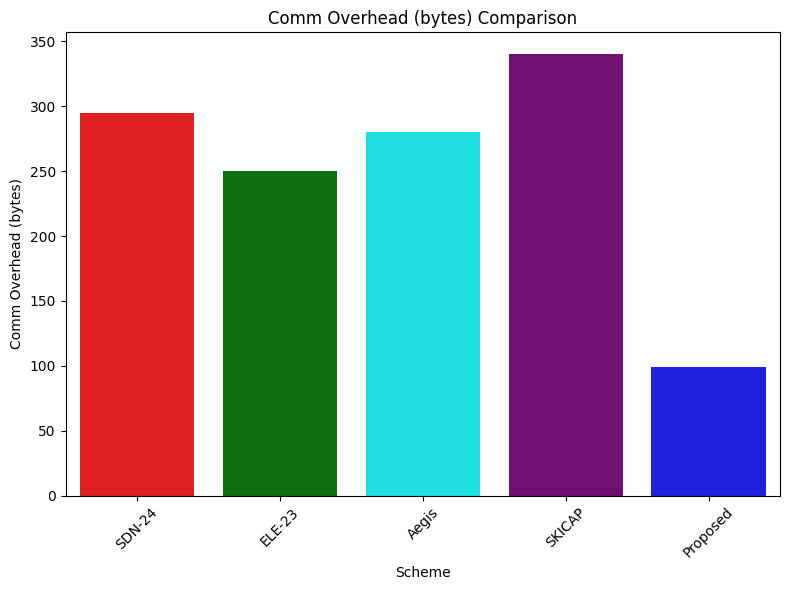

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import secrets
import os
import time
import hashlib
import sys
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305
from cryptography.hazmat.backends import default_backend
import json
from joblib import dump, load
import random
from tinyec import registry
from pysmt.shortcuts import Symbol, And, Implies, Not, Bool, Solver, Or
from pysmt.typing import BOOL
import logging
from ascon import encrypt, decrypt
np.random.seed(42)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load and preprocess dataset
try:
    df = pd.read_csv('/content/hybrid.csv')
    logging.info("Dataset loaded successfully. Shape: %s", df.shape)
except FileNotFoundError:
    logging.error("Dataset 'hybrid.csv' not found.")
    sys.exit(1)

# Enhanced preprocessing
df['Entropy'] = df['Entropy'].apply(lambda x: max(x, 0))
df = df.dropna()  # Handle missing values
sparse_columns = ['ICMP', 'ICMP6', 'LLC', 'SSDP', 'MDNS', 'NTP', 'IP_padding', 'IP_ralert']
df = df.drop(columns=sparse_columns, errors='ignore')
logging.info("Dropped sparse columns: %s", sparse_columns)

# Feature Engineering with realistic simulation
def generate_context_features(df):
    df['battery'] = df['TCP_w_size'].apply(lambda x: min(100, (x / 29480) * 100))
    # Simulate cpu_usage and memory_usage based on packet size and entropy
    df['cpu_usage'] = df['Pck_size'].apply(lambda x: min(90, max(10, (x / 765) * 50 + np.random.normal(0, 5))))
    df['memory_usage'] = df['Entropy'].apply(lambda x: min(90, max(10, (x / 5.59) * 60 + np.random.normal(0, 5))))
    df['data_size'] = df['Pck_size'] / 765
    df['sensitivity'] = (df['Entropy'] / 5.59) * 0.6 + (df['Pck_size'] / 765) * 0.4
    df['sensitivity'] = df['sensitivity'].clip(0, 1)
    df['data_type'] = df[['HTTP', 'UDP']].apply(
        lambda x: 'video' if x['HTTP'] > 0 else ('telemetry' if x['UDP'] > 0 else 'other'), axis=1
    )
    df['data_type'] = LabelEncoder().fit_transform(df['data_type'])  # Encode categorical feature
    df['bandwidth'] = df['IP_add_count'].apply(lambda x: min(100, x * 20))
    df['latency'] = df['Portcl_src'].apply(lambda x: min(50, x * 10))
    df['congestion'] = df['Portcl_dst'].apply(lambda x: min(1, x / 10))
    return df

df = generate_context_features(df)
context_features = ['battery', 'cpu_usage', 'memory_usage', 'data_size', 'sensitivity', 'data_type', 'bandwidth', 'latency', 'congestion']

# Synthetic Labels
def generate_synthetic_labels(df):
    e_alg, k_freq = [], []
    for _, row in df.iterrows():
        sens_j = row['sensitivity']
        if sens_j > 0.8:
            e_alg.append('AES-128-GCM')
        elif sens_j > 0.4:
            e_alg.append('ChaCha20-Poly1305')
        else:
            e_alg.append('ASCON-128')
        k_freq.append(1 / (10 / max(sens_j, 0.1)))
    return pd.DataFrame({'e_alg': e_alg, 'k_freq': k_freq})

y_df = generate_synthetic_labels(df)
e_alg_encoder = LabelEncoder()
y_df['e_alg'] = e_alg_encoder.fit_transform(y_df['e_alg'])

X = df[context_features]
y = y_df[['e_alg', 'k_freq']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y['e_alg'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_scaled, y_train_e_alg = smote.fit_resample(X_train_scaled, y_train['e_alg'])
y_train_k_freq = np.repeat(y_train['k_freq'].values, X_train_scaled.shape[0] // X_train.shape[0], axis=0)
if len(y_train_k_freq) < X_train_scaled.shape[0]:
    y_train_k_freq = np.pad(y_train_k_freq, (0, X_train_scaled.shape[0] - len(y_train_k_freq)), mode='edge')
y_train = pd.DataFrame({'e_alg': y_train_e_alg, 'k_freq': y_train_k_freq})

# Hyperparameter tuning for models
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3]}
classifier = GridSearchCV(XGBClassifier(random_state=42, eval_metric='mlogloss'), param_grid, cv=5, n_jobs=-1)
regressor = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)
classifier.fit(X_train_scaled, y_train['e_alg'])
regressor.fit(X_train_scaled, y_train['k_freq'])
logging.info("Best classifier params: %s", classifier.best_params_)
logging.info("Best regressor params: %s", regressor.best_params_)
dump(classifier.best_estimator_, '/content/context_classifier.joblib')
dump(regressor.best_estimator_, '/content/context_regressor.joblib')

# Evaluate
y_pred_e_alg = classifier.predict(X_test_scaled)
y_pred_k_freq = regressor.predict(X_test_scaled)
print("\nEncryption Algorithm Classification Report:")
print(classification_report(y_test['e_alg'], y_pred_e_alg, target_names=e_alg_encoder.classes_))
print(f"\nKey Rotation Frequency MSE: {mean_squared_error(y_test['k_freq'], y_pred_k_freq):.2e}")

# Graphs
cm_e_alg = confusion_matrix(y_test['e_alg'], y_pred_e_alg)
cm_percentage = cm_e_alg / cm_e_alg.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=e_alg_encoder.classes_, yticklabels=e_alg_encoder.classes_)
plt.title('Encryption Algorithm Confusion Matrix (%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("e_alg_confusion.pdf")
plt.show()

feature_importance = pd.DataFrame({
    'Feature': context_features,
    'Importance_e_alg': classifier.best_estimator_.feature_importances_,
    'Importance_k_freq': regressor.best_estimator_.feature_importances_
}).melt(id_vars='Feature', var_name='Target', value_name='Importance')
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', hue='Target', data=feature_importance)
plt.title('Feature Importance for Encryption Algorithm and Key Rotation')
plt.savefig("feature_importance.pdf")
plt.show()

e_alg_counts = pd.Series(e_alg_encoder.inverse_transform(y_pred_e_alg)).value_counts()
plt.figure(figsize=(8, 6))
e_alg_counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Predicted Encryption Algorithm Distribution')
plt.xlabel('Encryption Algorithm')
plt.ylabel('Count')
plt.savefig("e_alg_distribution.pdf")
plt.show()

cv_scores_e_alg = cross_val_score(classifier.best_estimator_, X_train_scaled, y_train['e_alg'], cv=5, scoring='accuracy')
cv_scores_k_freq = cross_val_score(regressor.best_estimator_, X_train_scaled, y_train['k_freq'], cv=5, scoring='neg_mean_squared_error')
cv_scores_k_freq = -cv_scores_k_freq
plt.figure(figsize=(10, 6))
plt.boxplot([cv_scores_e_alg, cv_scores_k_freq], labels=['Accuracy (e_alg)', 'MSE (k_freq)'])
plt.title('Cross-Validation Scores')
plt.ylabel('Score')
plt.savefig("cv_scores.pdf")
plt.show()

class SDN_Controller:
    def __init__(self):
        self.keys = {'AES-128-GCM': secrets.token_bytes(16), 'ChaCha20-Poly1305': secrets.token_bytes(32), 'ASCON-128': secrets.token_bytes(16)}
        self.device_registry = {}
        self.curve = registry.get_curve('brainpoolP256r1')
        self.private_key = secrets.randbelow(self.curve.field.n)
        self.public_key = self.private_key * self.curve.g
        self.iot_edge_public_key = None
        self.iot_server_public_key = None
        self.iot_edge_aes_key = None
        self.iot_server_aes_key = None
        self.classifier = load('/content/context_classifier.joblib')
        self.regressor = load('/content/context_regressor.joblib')
        self.e_alg_encoder = LabelEncoder().fit(['ASCON-128', 'AES-128-GCM', 'ChaCha20-Poly1305'])
        self.metrics = {'execution_times': [], 'energy_consumptions': [], 'comm_overheads': []}
        self.e_alg_codes = {'ASCON-128': 0, 'AES-128-GCM': 1, 'ChaCha20-Poly1305': 2}

    def get_public_key(self):
        return {'x': self.public_key.x, 'y': self.public_key.y}

    def collect_metrics(self, execution_time, energy_consumption_mj, comm_overhead):
        self.metrics['execution_times'].append(execution_time * 1000)
        self.metrics['energy_consumptions'].append(energy_consumption_mj)
        self.metrics['comm_overheads'].append(comm_overhead)

    def get_proposed_metrics(self):
        if self.device_registry:
            total_memory = 0
            for details in self.device_registry.values():
                memory = (
                    32 +           # Private key (256-bit integer)
                    64 +           # Controller's public key (two 256-bit integers)
                    len(details['key']) +  # Session key (16 or 32 bytes)
                    16 +           # UUID (128 bits)
                    6              # MAC address (48 bits)
                )
                total_memory += memory
            avg_memory = total_memory / len(self.device_registry)
        else:
            avg_memory = 134
        avg_execution_time = np.mean(self.metrics['execution_times']) if self.metrics['execution_times'] else 0
        avg_energy = np.mean(self.metrics['energy_consumptions']) if self.metrics['energy_consumptions'] else 0
        avg_comm_overhead = np.mean(self.metrics['comm_overheads']) if self.metrics['comm_overheads'] else 0
        return [int(avg_memory), avg_energy, avg_execution_time, int(avg_comm_overhead)]

    def encrypt_AES_GCM(self, msg, secretKey):
        try:
            start_time = time.time()
            nonce = secrets.token_bytes(12)  # Secure random nonce
            cipher = Cipher(algorithms.AES(secretKey), modes.GCM(nonce), backend=default_backend())
            encryptor = cipher.encryptor()
            ciphertext = encryptor.update(msg) + encryptor.finalize()
            execution_time = time.time() - start_time
            comm_overhead = len(ciphertext) + len(nonce) + len(encryptor.tag)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return ciphertext, nonce, encryptor.tag
        except Exception as e:
            logging.error("AES-GCM encryption failed: %s", e)
            return None, None, None

    def decrypt_AES_GCM(self, ciphertext, nonce, authTag, secretKey):
        try:
            start_time = time.time()
            cipher = Cipher(algorithms.AES(secretKey), modes.GCM(nonce, authTag), backend=default_backend())
            decryptor = cipher.decryptor()
            plaintext = decryptor.update(ciphertext) + decryptor.finalize()
            execution_time = time.time() - start_time
            comm_overhead = len(ciphertext) + len(nonce) + len(authTag)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return plaintext
        except Exception as e:
            logging.error("AES-GCM decryption failed: %s", e)
            return None

    def encrypt_ChaCha20(self, msg, secretKey):
        try:
            start_time = time.time()
            aead = ChaCha20Poly1305(secretKey)
            nonce = secrets.token_bytes(12)
            ciphertext = aead.encrypt(nonce, msg, None)
            execution_time = time.time() - start_time
            comm_overhead = len(ciphertext) + len(nonce)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return ciphertext, nonce
        except Exception as e:
            logging.error("ChaCha20 encryption failed: %s", e)
            return None, None

    def decrypt_ChaCha20(self, ciphertext, nonce, secretKey):
        try:
            start_time = time.time()
            aead = ChaCha20Poly1305(secretKey)
            plaintext = aead.decrypt(nonce, ciphertext, None)
            execution_time = time.time() - start_time
            comm_overhead = len(ciphertext) + len(nonce)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return plaintext
        except Exception as e:
            logging.error("ChaCha20 decryption failed: %s", e)
            return None

    def encrypt_ASCON(self, msg, secretKey):
        start_time = time.time()
        nonce = os.urandom(16)  # 128-bit nonce for ASCON-128
        try:
            # Validate inputs
            if not isinstance(msg, bytes):
                print(f"ASCON-128 Encryption Error: Message must be bytes, got {type(msg)}")
                return None, None, None
            if len(secretKey) != 16:
                print(f"ASCON-128 Encryption Error: Key must be 16 bytes, got {len(secretKey)} bytes")
                return None, None, None
            result = encrypt(key=secretKey, nonce=nonce, associateddata=b'', plaintext=msg, variant="Ascon-128")
            # Assume result is concatenated ciphertext and tag (tag is 16 bytes)
            ciphertext = result[:-16]
            tag = result[-16:]
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"ASCON-128 Encryption Computation Time: {execution_time*1000:.2f} ms")
            return ciphertext, nonce, tag
        except Exception as e:
            print(f"ASCON-128 Encryption Error: {e}")
            return None, None, None

    def decrypt_ASCON(self, ciphertext, nonce, authTag, secretKey):
        start_time = time.time()
        try:
            # Validate inputs
            if not isinstance(ciphertext, bytes) or not isinstance(authTag, bytes) or not isinstance(nonce, bytes):
                print(f"ASCON-128 Decryption Error: Inputs must be bytes, got ciphertext={type(ciphertext)}, tag={type(authTag)}, nonce={type(nonce)}")
                return None
            if len(secretKey) != 16:
                print(f"ASCON-128 Decryption Error: Key must be 16 bytes, got {len(secretKey)} bytes")
                return None
            # Recombine ciphertext and tag for decryption
            full_ciphertext = ciphertext + authTag
            plaintext = decrypt(key=secretKey, nonce=nonce, associateddata=b'', ciphertext=full_ciphertext, variant="Ascon-128")
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"ASCON-128 Decryption Computation Time: {execution_time*1000:.2f} ms")
            return plaintext
        except Exception as e:
            print(f"ASCON-128 Decryption Error: {e}")
            return None


    def ecc_point_to_256_bit_key(self, point):
        try:
            start_time = time.time()
            sha = hashlib.sha256(int.to_bytes(point.x, 32, 'big'))
            sha.update(int.to_bytes(point.y, 32, 'big'))
            result = sha.digest()
            execution_time = time.time() - start_time
            comm_overhead = len(result)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return result
        except Exception as e:
            logging.error("ECC key generation failed: %s", e)
            return None

    def encrypt_ECC(self, msg, pubKey):
        try:
            start_time = time.time()
            ciphertextPrivKey = secrets.randbelow(self.curve.field.n)
            sharedECCKey = ciphertextPrivKey * pubKey
            secretKey = self.ecc_point_to_256_bit_key(sharedECCKey)
            if secretKey is None:
                return None
            ciphertext, nonce, authTag = self.encrypt_AES_GCM(msg, secretKey)
            if ciphertext is None:
                return None
            ciphertextPubKey = ciphertextPrivKey * self.curve.g
            execution_time = time.time() - start_time
            comm_overhead = len(ciphertext) + len(nonce) + len(authTag) + sys.getsizeof(ciphertextPubKey)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return (ciphertext, nonce, authTag, ciphertextPubKey)
        except Exception as e:
            logging.error("ECC encryption failed: %s", e)
            return None

    def decrypt_ECC(self, encryptedMsg, privKey):
        try:
            start_time = time.time()
            if not isinstance(encryptedMsg, tuple) or len(encryptedMsg) != 4:
                raise ValueError("Invalid encrypted message format for ECC")
            ciphertext, nonce, authTag, ciphertextPubKey = encryptedMsg
            sharedECCKey = privKey * ciphertextPubKey
            secretKey = self.ecc_point_to_256_bit_key(sharedECCKey)
            if secretKey is None:
                return None
            plaintext = self.decrypt_AES_GCM(ciphertext, nonce, authTag, secretKey)
            if plaintext is None:
                return None
            execution_time = time.time() - start_time
            comm_overhead = len(ciphertext) + len(nonce) + len(authTag) + sys.getsizeof(ciphertextPubKey)
            self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
            return plaintext
        except Exception as e:
            logging.error("ECC decryption failed: %s", e)
            return None

    def predict_context(self, context_data):
        try:
            context_scaled = scaler.transform(context_data)
            e_alg_pred = self.classifier.predict(context_scaled)
            k_freq_pred = self.regressor.predict(context_scaled)
            e_alg = self.e_alg_encoder.inverse_transform(e_alg_pred)[0]
            return {'e_alg': e_alg, 'k_freq': k_freq_pred[0]}
        except Exception as e:
            logging.error("Context prediction failed: %s", e)
            return {'e_alg': 'AES-128-GCM', 'k_freq': 0.1}

    def rotate_key(self, device_uuid):
        try:
            start_time = time.time()
            if device_uuid in self.device_registry:
                context_data = df[df['Label'] == self.device_registry[device_uuid]['mac'].decode('utf-8')][context_features].head(1)
                if not context_data.empty:
                    context_pred = self.predict_context(context_data)
                    key_size = {'ASCON-128': 16, 'AES-128-GCM': 16, 'ChaCha20-Poly1305': 32}
                    new_key = secrets.token_bytes(key_size[context_pred['e_alg']])
                    self.device_registry[device_uuid].update({
                        'key': new_key,
                        'e_alg': self.e_alg_codes[context_pred['e_alg']],
                        'k_freq': context_pred['k_freq'],
                        'last_rotation': time.time()
                    })
                    execution_time = time.time() - start_time
                    self.collect_metrics(execution_time, execution_time * 1.5 * 1000, len(new_key))
                    return new_key
            return None
        except Exception as e:
            logging.error("Key rotation failed for %s: %s", device_uuid, e)
            return None

    def register_device(self, encryptedMsg, iot_edge_public_key=None):
        try:
            start_time = time.time()
            if iot_edge_public_key:
                if not isinstance(encryptedMsg, tuple) or len(encryptedMsg) != 4:
                    raise ValueError("Invalid encrypted message format for ECC")
                device_info = self.decrypt_ECC(encryptedMsg, self.private_key)
                if device_info is None:
                    return None
                device_uuid, mac_address, device_type = device_info.decode('utf-8').split(',', 2)
                if device_type == "edge":
                    self.iot_edge_public_key = iot_edge_public_key
                else:
                    self.iot_server_public_key = iot_edge_public_key
            else:
                if not isinstance(encryptedMsg, tuple) or len(encryptedMsg) != 3:
                    raise ValueError("Invalid encrypted message format for ASCON")
                ciphertext, nonce, authTag = encryptedMsg
                device_info = self.decrypt_ASCON(ciphertext, nonce, authTag, self.iot_edge_aes_key)
                if device_info is None:
                    return None
                device_uuid, mac_address, device_type = device_info.decode('utf-8').split(',', 2)

            if device_uuid not in self.device_registry:
                context_data = df[df['Label'] == mac_address][context_features].head(1)
                context_pred = self.predict_context(context_data) if not context_data.empty else {'e_alg': 'AES-128-GCM', 'k_freq': 0.1}
                key_size = {'ASCON-128': 16, 'AES-128-GCM': 16, 'ChaCha20-Poly1305': 32}[context_pred['e_alg']]
                key = secrets.token_bytes(key_size)
                self.device_registry[device_uuid] = {
                    'key': key,
                    'mac': mac_address.encode('utf-8'),
                    'e_alg': self.e_alg_codes[context_pred['e_alg']],
                    'k_freq': context_pred['k_freq'],
                    'last_rotation': time.time()
                }
                if device_type == "edge" and self.iot_edge_aes_key is None:
                    self.iot_edge_aes_key = key
                    encrypted_key = self.encrypt_ECC(key, self.iot_edge_public_key)
                    if encrypted_key is None:
                        return None
                    execution_time = time.time() - start_time
                    comm_overhead = sum(len(x) for x in encrypted_key[:3]) + sys.getsizeof(encrypted_key[3])
                    self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
                    return encrypted_key
                elif device_type == "server" and self.iot_server_aes_key is None:
                    self.iot_server_aes_key = key
                    encrypted_key = self.encrypt_ECC(key, self.iot_server_public_key)
                    if encrypted_key is None:
                        return None
                    execution_time = time.time() - start_time
                    comm_overhead = sum(len(x) for x in encrypted_key[:3]) + sys.getsizeof(encrypted_key[3])
                    self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
                    return encrypted_key
                execution_time = time.time() - start_time
                comm_overhead = sum(len(x) if isinstance(x, bytes) else sys.getsizeof(x) for x in encryptedMsg)
                self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
                return "Device registered successfully."
            return None
        except Exception as e:
            logging.error("Device registration failed: %s", e)
            return None

    def auth_device(self, encryptedMsg):
        try:
            start_time = time.time()
            if not isinstance(encryptedMsg, tuple) or len(encryptedMsg) != 3:
                raise ValueError("Invalid encrypted message format for authentication")
            ciphertext, nonce, authTag = encryptedMsg
            device_info = self.decrypt_ASCON(ciphertext, nonce, authTag, self.iot_edge_aes_key)
            if device_info is None:
                return None, None, None
            device_uuid, mac_address, _ = device_info.decode('utf-8').split(',', 2)
            if device_uuid in self.device_registry and self.device_registry[device_uuid]['mac'] == mac_address.encode('utf-8'):
                session_key = self.device_registry[device_uuid]['key']
                encrypted_session_key, nonce, tag = self.encrypt_AES_GCM(session_key, self.iot_edge_aes_key)
                if encrypted_session_key is None:
                    return None, None, None
                execution_time = time.time() - start_time
                comm_overhead = len(encrypted_session_key) + len(tag) + len(nonce)
                self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
                return encrypted_session_key, tag, nonce
            return None, None, None
        except Exception as e:
            logging.error("Device authentication failed: %s", e)
            return None, None, None

    def send_all_keys_to_server(self):
        try:
            start_time = time.time()
            if self.iot_server_aes_key:
                device_info = [{'uuid': uuid, 'key': details['key'].hex(), 'mac': details['mac'].decode('utf-8')} for uuid, details in self.device_registry.items()]
                device_info_json = json.dumps(device_info).encode('utf-8')
                encrypted_data, tag, nonce = self.encrypt_ASCON(device_info_json, self.iot_server_aes_key)
                if encrypted_data is None:
                    return None, None, None
                execution_time = time.time() - start_time
                comm_overhead = len(encrypted_data) + len(tag) + len(nonce)
                self.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
                return encrypted_data, tag, nonce
            return None, None, None
        except Exception as e:
            logging.error("Sending keys to server failed: %s", e)
            return None, None, None

    def verify_protocol(self):
        # Expanded threat models
        controller_sends_key = Symbol("controller_sends_key", BOOL)
        edge_receives_key = Symbol("edge_receives_key", BOOL)
        intruder_intercepts_key = Symbol("intruder_intercepts_key", BOOL)
        intruder_knows_receiver_priv_key = Symbol("intruder_knows_receiver_priv_key", BOOL)
        intruder_knows_shared_key = Symbol("intruder_knows_shared_key", BOOL)
        intruder_knows_aes_key = Symbol("intruder_knows_aes_key", BOOL)
        edge_sends_message = Symbol("edge_sends_message", BOOL)
        server_receives_message = Symbol("server_receives_message", BOOL)
        intruder_intercepts_message = Symbol("intruder_intercepts_message", BOOL)
        intruder_knows_message = Symbol("intruder_knows_message", BOOL)
        intruder_knows_nonce = Symbol("intruder_knows_nonce", BOOL)
        edge_authenticates = Symbol("edge_authenticates", BOOL)
        server_authenticates = Symbol("server_authenticates", BOOL)
        secure_channel = Symbol("secure_channel", BOOL)
        message_encrypted = Symbol("message_encrypted", BOOL)
        message_valid = Symbol("message_valid", BOOL)
        replay_attack = Symbol("replay_attack", BOOL)

        protocol = And(
            Implies(controller_sends_key, And(secure_channel, Or(edge_receives_key, intruder_intercepts_key))),
            Implies(intruder_knows_shared_key, intruder_knows_receiver_priv_key),
            Implies(intruder_knows_aes_key, And(intruder_knows_shared_key, intruder_intercepts_key)),
            Implies(edge_sends_message, And(message_encrypted, secure_channel, Or(server_receives_message, intruder_intercepts_message))),
            Implies(server_receives_message, And(message_valid, server_authenticates, Not(replay_attack))),
            Implies(message_valid, edge_sends_message),
            Implies(intruder_knows_message, And(intruder_intercepts_message, intruder_knows_aes_key, intruder_knows_nonce)),
            Implies(edge_receives_key, edge_authenticates),
            Not(intruder_knows_shared_key),
            Not(intruder_knows_aes_key),
            Not(intruder_knows_message),
            secure_channel,
            message_encrypted
        )

        threat_models = [
            {"name": "ECC Key Secure, Nonce Secure", "assertion": And(Not(intruder_knows_receiver_priv_key), Not(intruder_knows_nonce), Not(replay_attack))},
            {"name": "ECC Key Compromised", "assertion": intruder_knows_receiver_priv_key},
            {"name": "Nonce Compromised", "assertion": intruder_knows_nonce},
            {"name": "Replay Attack", "assertion": replay_attack}
        ]

        for tm in threat_models:
            with Solver(name="z3") as solver:
                solver.add_assertion(protocol)
                solver.add_assertion(tm["assertion"])
                secrecy_holds = not solver.solve([intruder_knows_message])
                auth_holds = not solver.solve([server_receives_message, Not(edge_sends_message)])
                print(f"Verification for {tm['name']}:")
                print(f"  Secrecy: {'Holds' if secrecy_holds else 'Does not hold'}")
                print(f"  Authentication: {'Holds' if auth_holds else 'Does not hold'}")

        if self.device_registry:
            key_freqs_by_alg = {alg: [] for alg in self.e_alg_codes.keys()}
            for details in self.device_registry.values():
                alg = self.e_alg_encoder.inverse_transform([details['e_alg']])[0]
                key_freqs_by_alg[alg].append(details['k_freq'])

            all_freqs = [freq for freqs in key_freqs_by_alg.values() for freq in freqs]
            if all_freqs:
                bins = np.histogram_bin_edges(all_freqs, bins=20)
                colors = {'ASCON-128': 'blue', 'AES-128-GCM': 'green', 'ChaCha20-Poly1305': 'red'}
                plt.figure(figsize=(10, 6))
                for alg, freqs in key_freqs_by_alg.items():
                    if freqs:
                        plt.hist(freqs, bins=bins, alpha=0.5, label=alg, color=colors[alg])
                plt.title('Key Rotation Frequency Distribution by Encryption Algorithm')
                plt.xlabel('Frequency (rotations/min)')
                plt.ylabel('Number of Devices')
                plt.legend()
                plt.savefig("key_rotation_frequency_by_alg.pdf")
                plt.show()

class Iot_Edge:
    def __init__(self, controller):
        self.controller = controller
        self.curve = registry.get_curve('brainpoolP256r1')
        self.private_key = secrets.randbelow(self.curve.field.n)
        self.public_key = self.private_key * self.curve.g
        self.iot_edge_aes_key = None
        self.iot_edge_uuid = str(uuid.uuid4())
        self.iot_mac = self.generate_mac_address()
        self.device_uuids = {}
        self.device_uuids_keys = {}
        self.device_names = []
        self.controller_public_key = self.curve.g.__class__(self.curve, *controller.get_public_key().values())
        self.register_self()

    def generate_mac_address(self):
        mac = [0x00, 0x16, 0x3e, random.randint(0x00, 0x7f), random.randint(0x00, 0xff), random.randint(0x00, 0xff)]
        return ':'.join(map(lambda x: "%02x" % x, mac)).encode('utf-8')

    def encrypt_ECC(self, msg, pubKey):
        return self.controller.encrypt_ECC(msg, pubKey)

    def decrypt_ECC(self, encryptedMsg, privKey):
        return self.controller.decrypt_ECC(encryptedMsg, privKey)

    def register_self(self):
        encrypted_device_info = self.encrypt_ECC(f"{self.iot_edge_uuid},{self.iot_mac.decode('utf-8')},edge".encode('utf-8'), self.controller_public_key)
        if encrypted_device_info:
            key = self.controller.register_device(encrypted_device_info, self.public_key)
            if key:
                self.iot_edge_aes_key = self.decrypt_ECC(key, self.private_key)

    def register_device_with_uuid(self, device_name, mac_address):
        if device_name not in self.device_uuids:
            uid = str(uuid.uuid4())
            self.device_uuids[device_name] = {'uuid': uid, 'mac': mac_address.encode('utf-8')}
            self.device_names.append(device_name)

    def predict_and_register_device(self, X_test_scaled, df, classifier, max_devices=10):
        y_pred_e_alg = classifier.predict(X_test_scaled)
        device_names = df['Label'].unique()[:max_devices]
        for name in device_names:
            mac_address = name
            self.register_device_with_uuid(name, mac_address)
            uid = self.device_uuids[name]['uuid']
            encrypted_device_info = self.controller.encrypt_ASCON(f"{uid},{mac_address},iot".encode('utf-8'), self.iot_edge_aes_key)
            if encrypted_device_info:
                self.controller.register_device(encrypted_device_info)

    def request_auth(self):
        for name in self.device_names:
            start_time = time.time()
            device_info = self.device_uuids[name]
            uid, mac_address = device_info['uuid'], device_info['mac'].decode('utf-8')
            encrypted_device_info = self.controller.encrypt_ASCON(f"{uid},{mac_address},iot".encode('utf-8'), self.iot_edge_aes_key)
            if encrypted_device_info:
                encrypted_session_key, tag, nonce = self.controller.auth_device(encrypted_device_info)
                if encrypted_session_key:
                    session_key = self.controller.decrypt_AES_GCM(encrypted_session_key, nonce, tag, self.iot_edge_aes_key)
                    if session_key:
                        self.device_uuids_keys[uid] = session_key
                        execution_time = time.time() - start_time
                        comm_overhead = len(encrypted_session_key) + len(tag) + len(nonce)
                        self.controller.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)

    def send_msg_to_server(self, server):
        for uid, key in self.device_uuids_keys.items():
            start_time = time.time()
            random_message = secrets.token_bytes(100)
            combined_message = f"{uid},{random_message.hex()}".encode('utf-8')
            encrypted_message, tag, nonce = self.controller.encrypt_ASCON(combined_message, key)
            if encrypted_message:
                server.receive_msg(encrypted_message, tag, nonce)
                execution_time = time.time() - start_time
                comm_overhead = len(encrypted_message) + len(tag) + len(nonce)
                self.controller.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)

class Server:
    def __init__(self, controller):
        self.controller = controller
        self.curve = registry.get_curve('brainpoolP256r1')
        self.private_key = secrets.randbelow(self.curve.field.n)
        self.public_key = self.private_key * self.curve.g
        self.server_aes_key = None
        self.server_uuid = str(uuid.uuid4())
        self.server_mac = self.generate_mac_address()
        self.device_uuids_keys = {}
        self.controller_public_key = self.curve.g.__class__(self.curve, *controller.get_public_key().values())
        self.register_self()

    def generate_mac_address(self):
        mac = [0x00, 0x16, 0x3e, random.randint(0x00, 0x7f), random.randint(0x00, 0xff), random.randint(0x00, 0xff)]
        return ':'.join(map(lambda x: "%02x" % x, mac)).encode('utf-8')

    def register_self(self):
        encrypted_device_info = self.controller.encrypt_ECC(f"{self.server_uuid},{self.server_mac.decode('utf-8')},server".encode('utf-8'), self.controller_public_key)
        if encrypted_device_info:
            key = self.controller.register_device(encrypted_device_info, self.public_key)
            if key:
                self.server_aes_key = self.controller.decrypt_ECC(key, self.private_key)

    def request_keys(self):
        encrypted_data, auth_tag, nonce = self.controller.send_all_keys_to_server()
        if encrypted_data:
            decrypted_data = self.controller.decrypt_ASCON(encrypted_data, auth_tag, nonce, self.server_aes_key)
            if decrypted_data:
                device_info_list = json.loads(decrypted_data.decode('utf-8'))
                for device_info in device_info_list:
                    self.device_uuids_keys[device_info['uuid']] = bytes.fromhex(device_info['key'])

    def receive_msg(self, encrypted_message, tag, nonce):
        for uid, key in self.device_uuids_keys.items():
            try:
                start_time = time.time()
                decrypted_data = self.controller.decrypt_ASCON(encrypted_message, tag, nonce, key)
                if decrypted_data:
                    message_uuid, _ = decrypted_data.decode('utf-8').split(',', 1)
                    if message_uuid == uid:
                        execution_time = time.time() - start_time
                        comm_overhead = len(encrypted_message) + len(tag) + len(nonce)
                        self.controller.collect_metrics(execution_time, execution_time * 1.5 * 1000, comm_overhead)
                        break
            except:
                continue

# Main Execution
controller = SDN_Controller()
iot_edge = Iot_Edge(controller)
server = Server(controller)
iot_edge.predict_and_register_device(X_test_scaled, df, classifier.best_estimator_, max_devices=10)
iot_edge.request_auth()
server.request_keys()
iot_edge.send_msg_to_server(server)

print("\nPerforming Formal Verification:")
controller.verify_protocol()

for device_uuid in list(controller.device_registry.keys()):
    k_freq = controller.device_registry[device_uuid]['k_freq']
    interval = 1 / k_freq * 60
    if (time.time() - controller.device_registry[device_uuid]['last_rotation']) > interval:
        controller.rotate_key(device_uuid)

proposed_metrics = controller.get_proposed_metrics()
comparison_data = {
    'Scheme': ['SDN-24', 'ELE-23', 'Aegis', 'SKICAP', 'Proposed'],
    'Memory (bytes)': [215, 180, 200, 195, proposed_metrics[0]],
    'Energy (mJ)': [190, 160, 180, 280, proposed_metrics[1]],
    'Execution Time (ms)': [16, 12, 18, 22, proposed_metrics[2]],
    'Comm Overhead (bytes)': [295, 250, 280, 340, proposed_metrics[3]]
}
comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Comparison with Static AES-256 Baseline:")
print(comparison_df)

comparison_df_melted = comparison_df.melt(id_vars='Scheme', var_name='Metric', value_name='Value')
metrics = ['Memory (bytes)', 'Energy (mJ)', 'Execution Time (ms)', 'Comm Overhead (bytes)']
color_map = {'Proposed': 'blue', 'SDN-24': 'red', 'ELE-23': 'green', 'Aegis': 'cyan', 'SKICAP': 'purple'}

for metric in metrics:
    metric_data = comparison_df_melted[comparison_df_melted['Metric'] == metric]
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Scheme', y='Value', hue='Scheme', data=metric_data, palette=color_map, legend=False)
    plt.title(f'{metric} Comparison')
    plt.xlabel('Scheme')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{metric.replace(' ', '_').lower()}_comparison.pdf")
    plt.show()

In [ ]:
from pysmt.shortcuts import Symbol, And, Implies, Not, Bool, Solver, Or
from pysmt.typing import BOOL
import matplotlib.pyplot as plt
import numpy as np

# Define symbols for protocol states and actions
controller_sends_key = Symbol("controller_sends_key", BOOL)
edge_receives_key = Symbol("edge_receives_key", BOOL)
intruder_intercepts_key = Symbol("intruder_intercepts_key", BOOL)
intruder_knows_receiver_priv_key = Symbol("intruder_knows_receiver_priv_key", BOOL)
intruder_knows_shared_key = Symbol("intruder_knows_shared_key", BOOL)
intruder_knows_aes_key = Symbol("intruder_knows_aes_key", BOOL)
edge_sends_message = Symbol("edge_sends_message", BOOL)
server_receives_message = Symbol("server_receives_message", BOOL)
intruder_intercepts_message = Symbol("intruder_intercepts_message", BOOL)
intruder_knows_message = Symbol("intruder_knows_message", BOOL)
intruder_knows_nonce = Symbol("intruder_knows_nonce", BOOL)
edge_authenticates = Symbol("edge_authenticates", BOOL)
server_authenticates = Symbol("server_authenticates", BOOL)
secure_channel = Symbol("secure_channel", BOOL)
message_encrypted = Symbol("message_encrypted", BOOL)
message_valid = Symbol("message_valid", BOOL)

# Define the protocol as a conjunction of logical constraints
protocol = And(
    Implies(controller_sends_key, And(secure_channel, Or(edge_receives_key, intruder_intercepts_key))),
    Implies(intruder_knows_shared_key, intruder_knows_receiver_priv_key),
    Implies(intruder_knows_aes_key, And(intruder_knows_shared_key, intruder_intercepts_key)),
    Implies(edge_sends_message, And(message_encrypted, secure_channel, Or(server_receives_message, intruder_intercepts_message))),
    Implies(server_receives_message, And(message_valid, server_authenticates)),
    Implies(message_valid, edge_sends_message),
    Implies(intruder_knows_message, And(intruder_intercepts_message, intruder_knows_aes_key, intruder_knows_nonce)),
    Implies(edge_receives_key, edge_authenticates),
    Not(intruder_knows_shared_key),
    Not(intruder_knows_aes_key),
    Not(intruder_knows_message),
    secure_channel,
    message_encrypted
)

# Define threat models
threat_models = [
    {"name": "ECC Key Secure, Nonce Secure", "assertion": And(Not(intruder_knows_receiver_priv_key), Not(intruder_knows_nonce))},
    {"name": "ECC Key Compromised", "assertion": intruder_knows_receiver_priv_key},
    {"name": "Nonce Compromised", "assertion": intruder_knows_nonce}
]

# Verify protocol under each threat model and collect results
results = []
for tm in threat_models:
    with Solver(name="z3") as solver:
        solver.add_assertion(protocol)
        solver.add_assertion(tm["assertion"])
        # Check secrecy: intruder does not know the message
        secrecy_holds = not solver.solve([intruder_knows_message])
        # Check authentication: if server receives message, then edge sent it
        auth_holds = not solver.solve([server_receives_message, Not(edge_sends_message)])
        results.append({
            "threat_model": tm["name"],
            "secrecy": 1 if secrecy_holds else 0,
            "authentication": 1 if auth_holds else 0
        })
        print(f"Verification for {tm['name']}:")
        print(f"  Secrecy: {'Holds' if secrecy_holds else 'Does not hold'}")
        print(f"  Authentication: {'Holds' if auth_holds else 'Does not hold'}")

# Plotව

# Plot the verification results as a bar graph
threat_models_names = [res["threat_model"] for res in results]
secrecy_values = [res["secrecy"] for res in results]
auth_values = [res["authentication"] for res in results]

x = np.arange(len(threat_models_names))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, secrecy_values, width, label='Secrecy', color='#4CAF50')
rects2 = ax.bar(x + width/2, auth_values, width, label='Authentication', color='#2196F3')

ax.set_ylabel('Status (1 = Holds, 0 = Does not hold)')
ax.set_title('Formal Verification Results')
ax.set_xticks(x)
ax.set_xticklabels(threat_models_names, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.savefig("formal_verification_results.pdf")
plt.show()

/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /usr/local/lib/python3.11/dist-packages/pysmt/smtlib/parser/parser.py
  tree = Parsing.p_module(s, pxd, full_module_name)


Verification for ECC Key Secure, Nonce Secure:
  Secrecy: Holds (Time: 0.59 ms)
  Authentication: Holds (Time: 0.21 ms)
Verification for ECC Key Compromised:
  Secrecy: Holds (Time: 0.48 ms)
  Authentication: Holds (Time: 0.20 ms)
Verification for Nonce Compromised:
  Secrecy: Holds (Time: 0.38 ms)
  Authentication: Holds (Time: 0.18 ms)


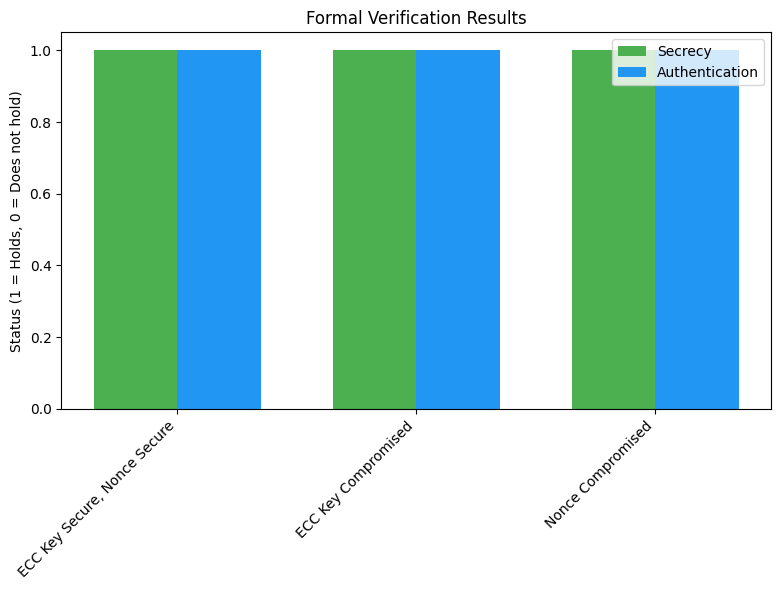

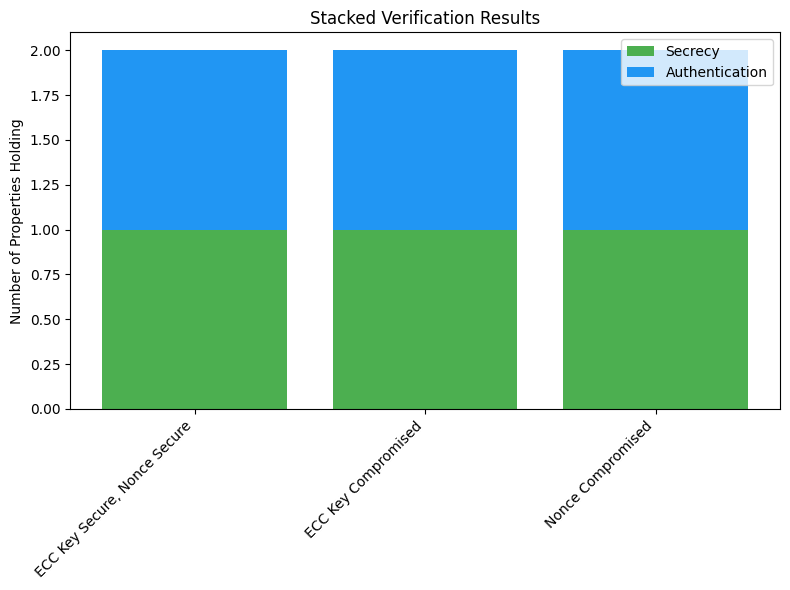

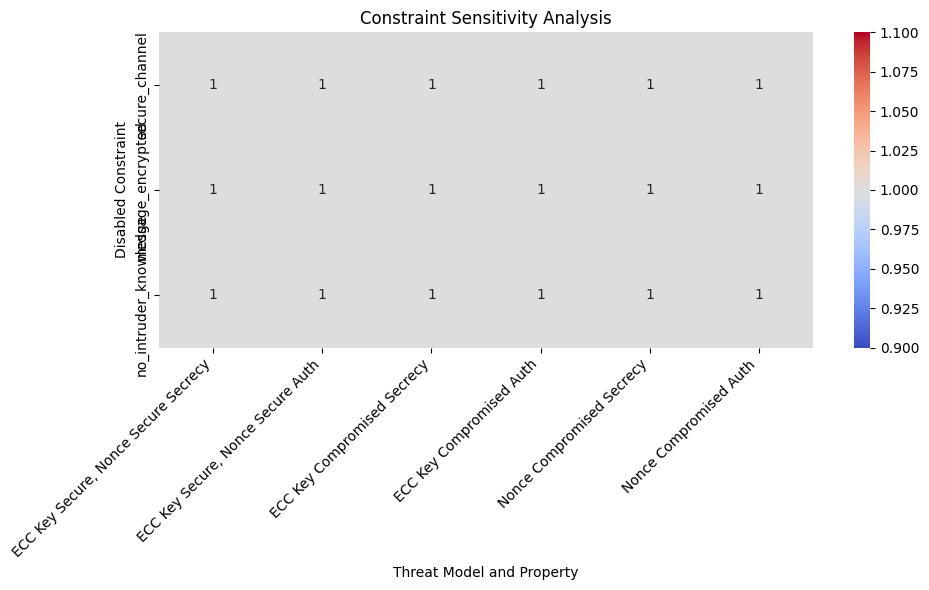

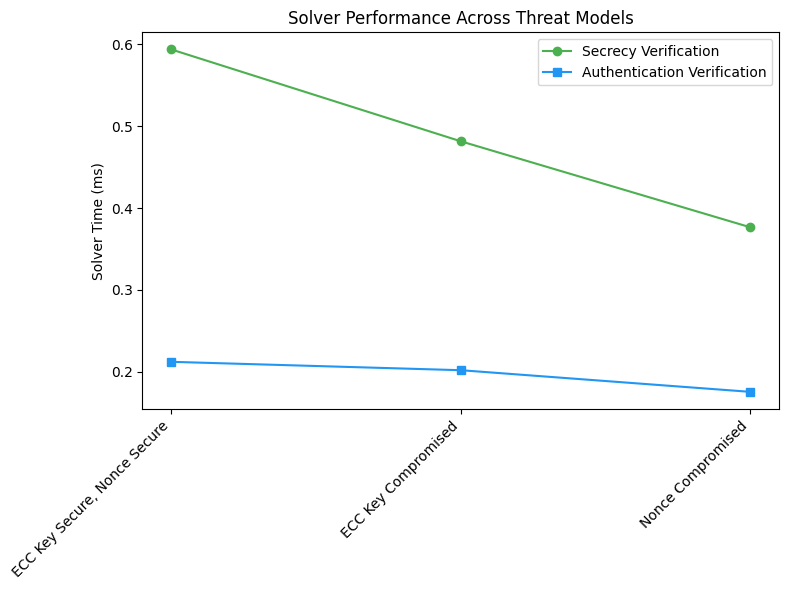

In [ ]:
from pysmt.shortcuts import Symbol, And, Implies, Not, Bool, Solver, Or
from pysmt.typing import BOOL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

# Define symbols for protocol states and actions
controller_sends_key = Symbol("controller_sends_key", BOOL)
edge_receives_key = Symbol("edge_receives_key", BOOL)
intruder_intercepts_key = Symbol("intruder_intercepts_key", BOOL)
intruder_knows_receiver_priv_key = Symbol("intruder_knows_receiver_priv_key", BOOL)
intruder_knows_shared_key = Symbol("intruder_knows_shared_key", BOOL)
intruder_knows_aes_key = Symbol("intruder_knows_aes_key", BOOL)
edge_sends_message = Symbol("edge_sends_message", BOOL)
server_receives_message = Symbol("server_receives_message", BOOL)
intruder_intercepts_message = Symbol("intruder_intercepts_message", BOOL)
intruder_knows_message = Symbol("intruder_knows_message", BOOL)
intruder_knows_nonce = Symbol("intruder_knows_nonce", BOOL)
edge_authenticates = Symbol("edge_authenticates", BOOL)
server_authenticates = Symbol("server_authenticates", BOOL)
secure_channel = Symbol("secure_channel", BOOL)
message_encrypted = Symbol("message_encrypted", BOOL)
message_valid = Symbol("message_valid", BOOL)

# Define the protocol as a conjunction of logical constraints
protocol = And(
    Implies(controller_sends_key, And(secure_channel, Or(edge_receives_key, intruder_intercepts_key))),
    Implies(intruder_knows_shared_key, intruder_knows_receiver_priv_key),
    Implies(intruder_knows_aes_key, And(intruder_knows_shared_key, intruder_intercepts_key)),
    Implies(edge_sends_message, And(message_encrypted, secure_channel, Or(server_receives_message, intruder_intercepts_message))),
    Implies(server_receives_message, And(message_valid, server_authenticates)),
    Implies(message_valid, edge_sends_message),
    Implies(intruder_knows_message, And(intruder_intercepts_message, intruder_knows_aes_key, intruder_knows_nonce)),
    Implies(edge_receives_key, edge_authenticates),
    Not(intruder_knows_shared_key),
    Not(intruder_knows_aes_key),
    Not(intruder_knows_message),
    secure_channel,
    message_encrypted
)

# Define threat models
threat_models = [
    {"name": "ECC Key Secure, Nonce Secure", "assertion": And(Not(intruder_knows_receiver_priv_key), Not(intruder_knows_nonce))},
    {"name": "ECC Key Compromised", "assertion": intruder_knows_receiver_priv_key},
    {"name": "Nonce Compromised", "assertion": intruder_knows_nonce}
]

# Verify protocol and collect results, including solver time
results = []
solver_times = []
for tm in threat_models:
    with Solver(name="z3") as solver:
        solver.add_assertion(protocol)
        solver.add_assertion(tm["assertion"])
        # Check secrecy
        start_time = time.time()
        secrecy_holds = not solver.solve([intruder_knows_message])
        secrecy_time = time.time() - start_time
        # Check authentication
        start_time = time.time()
        auth_holds = not solver.solve([server_receives_message, Not(edge_sends_message)])
        auth_time = time.time() - start_time
        results.append({
            "threat_model": tm["name"],
            "secrecy": 1 if secrecy_holds else 0,
            "authentication": 1 if auth_holds else 0
        })
        solver_times.append({
            "threat_model": tm["name"],
            "secrecy_time": secrecy_time * 1000,  # Convert to milliseconds
            "auth_time": auth_time * 1000
        })
        print(f"Verification for {tm['name']}:")
        print(f"  Secrecy: {'Holds' if secrecy_holds else 'Does not hold'} (Time: {secrecy_time*1000:.2f} ms)")
        print(f"  Authentication: {'Holds' if auth_holds else 'Does not hold'} (Time: {auth_time*1000:.2f} ms)")

# Sensitivity analysis: verify outcomes when disabling key constraints
constraints_to_test = [
    ("secure_channel", secure_channel),
    ("message_encrypted", message_encrypted),
    ("no_intruder_knowledge", Not(intruder_knows_shared_key))
]
sensitivity_results = []
for constraint_name, constraint in constraints_to_test:
    constraint_results = {"constraint": constraint_name}
    modified_protocol = And([c for c in protocol.args() if c != constraint])
    for tm in threat_models:
        with Solver(name="z3") as solver:
            solver.add_assertion(modified_protocol)
            solver.add_assertion(tm["assertion"])
            secrecy_holds = not solver.solve([intruder_knows_message])
            auth_holds = not solver.solve([server_receives_message, Not(edge_sends_message)])
            constraint_results[f"{tm['name']}_secrecy"] = 1 if secrecy_holds else 0
            constraint_results[f"{tm['name']}_auth"] = 1 if auth_holds else 0
    sensitivity_results.append(constraint_results)

# Plot 1: Side-by-Side Bar Chart (Original)
threat_models_names = [res["threat_model"] for res in results]
secrecy_values = [res["secrecy"] for res in results]
auth_values = [res["authentication"] for res in results]

x = np.arange(len(threat_models_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, secrecy_values, width, label='Secrecy', color='#4CAF50')
rects2 = ax.bar(x + width/2, auth_values, width, label='Authentication', color='#2196F3')

ax.set_ylabel('Status (1 = Holds, 0 = Does not hold)')
ax.set_title('Formal Verification Results')
ax.set_xticks(x)
ax.set_xticklabels(threat_models_names, rotation=45, ha='right')
ax.legend()
fig.tight_layout()
plt.savefig("formal_verification_results.pdf")
plt.show()

# Plot 2: Stacked Bar Chart
total_properties_holding = [res["secrecy"] + res["authentication"] for res in results]
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(threat_models_names, [res["secrecy"] for res in results], label='Secrecy', color='#4CAF50')
bars2 = ax.bar(threat_models_names, [res["authentication"] for res in results], bottom=[res["secrecy"] for res in results], label='Authentication', color='#2196F3')

ax.set_ylabel('Number of Properties Holding')
ax.set_title('Stacked Verification Results')
ax.set_xticks(range(len(threat_models_names)))
ax.set_xticklabels(threat_models_names, rotation=45, ha='right')
ax.legend()
fig.tight_layout()
plt.savefig("stacked_verification_results.pdf")
plt.show()

# Plot 3: Heatmap for Constraint Sensitivity
heatmap_data = np.array([
    [res[f"{tm['name']}_{prop}"] for tm in threat_models for prop in ["secrecy", "auth"]]
    for res in sensitivity_results
])
heatmap_labels = [f"{tm['name']} {'Secrecy' if prop == 'secrecy' else 'Auth'}" for tm in threat_models for prop in ["secrecy", "auth"]]

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap='coolwarm', xticklabels=heatmap_labels, yticklabels=[res["constraint"] for res in sensitivity_results])
ax.set_title('Constraint Sensitivity Analysis')
ax.set_xlabel('Threat Model and Property')
ax.set_ylabel('Disabled Constraint')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.savefig("constraint_sensitivity_heatmap.pdf")
plt.show()

# Plot 4: Line Plot for Solver Performance
secrecy_times = [st["secrecy_time"] for st in solver_times]
auth_times = [st["auth_time"] for st in solver_times]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(threat_models_names, secrecy_times, marker='o', label='Secrecy Verification', color='#4CAF50')
ax.plot(threat_models_names, auth_times, marker='s', label='Authentication Verification', color='#2196F3')

ax.set_ylabel('Solver Time (ms)')
ax.set_title('Solver Performance Across Threat Models')
ax.set_xticks(range(len(threat_models_names)))
ax.set_xticklabels(threat_models_names, rotation=45, ha='right')
ax.legend()
fig.tight_layout()
plt.savefig("solver_performance.pdf")
plt.show()